<a href="https://colab.research.google.com/github/tleitch/BDML/blob/main/scholastic_travel/stochastic_travel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fancyimpute

In [2]:
import pandas as pd
import xlrd
pd.options.mode.chained_assignment = None
#from fancyimpute import MICE
from fancyimpute import IterativeImputer as MICE
import copy
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
## sometimes in data ,people represent NA values differently. Pandas provide a way to input all possible NA values in form of list so that they are stored in memory as NA##
exhibit_1 = pd.read_csv("https://raw.githubusercontent.com/tleitch/BDML/main/scholastic_travel/exhibit_1.csv", na_values=["#N/A", "#N/A N/A", "#NA", "-1.#IND", "-1.#QNAN", "-NaN", "-nan", "1.#IND", "1.#QNAN", "N/A", "NA", "NULL", "NaN", "nan"])
exhibit_2 = pd.read_csv("https://raw.githubusercontent.com/tleitch/BDML/main/scholastic_travel/exhibit_2.csv",na_values = ["#N/A", "#N/A N/A", "#NA", "-1.#IND", "-1.#QNAN", "-NaN", "-nan", "1.#IND", "1.#QNAN", "N/A", "NA", "NULL", "NaN", "nan"])

exhibit_1 = exhibit_1[1:2389]
exhibit_2 = exhibit_2[1:2389]

In [6]:
exhibit_1.head()

,ID,Program.Code,From.Grade,To.Grade,Group.State,Is.Non.Annual.,Days,Travel.Type,Departure.Date,Return.Date,Deposit.Date,Special.Pay,Tuition,FRP.Active,FRP.Cancelled,FRP.Take.up.percent.,Early.RPL,Latest.RPL,Cancelled.Pax,Total.Discount.Pax,Initial.System.Date,Poverty.Code,Region,CRM.Segment,School.Type,Parent.Meeting.Flag,MDR.Low.Grade,MDR.High.Grade,Total.School.Enrollment,Income.Level,EZ.Pay.Take.Up.Rate,School.Sponsor,SPR.Product.Type,SPR.New.Existing,FPP,Total.Pax,SPR.Group.Revenue,NumberOfMeetingswithParents,FirstMeeting,LastMeeting,DifferenceTraveltoFirstMeeting,DifferenceTraveltoLastMeeting,SchoolGradeTypeLow,SchoolGradeTypeHigh,SchoolGradeType,DepartureMonth,GroupGradeTypeLow,GroupGradeTypeHigh,GroupGradeType,MajorProgramCode,SingleGradeTripFlag,FPP.to.School.enrollment,FPP.to.PAX,Num.of.Non_FPP.PAX,SchoolSizeIndicator,Retained.in.2012.
1,2,HC,8.0,8.0,AZ,0.0,7.0,A,14/01/2011,21/01/2011,15/11/2009,CP,2350.0,9.0,9.0,0.409,20/10/2009,10/08/2010,11.0,3.0,02/10/2009,C,Other,10.0,PUBLIC,1.0,7,8.0,850.0,A,0.091,0.0,East Coast,EXISTING,22.0,25.0,2350.0,2.0,17/11/2009,27/08/2010,423.0,140.0,Middle,Middle,Middle->Middle,January,Middle,Middle,Middle->Middle,H,1.0,0.025882,0.880000,3.0,L,1.0
2,3,HD,8.0,8.0,FL,0.0,3.0,A,15/01/2011,17/01/2011,15/10/2010,NaN,1181.0,17.0,6.0,0.708,29/04/2010,16/08/2010,6.0,3.0,28/01/2010,C,Other,10.0,PUBLIC,1.0,6,8.0,955.0,O,0.042,0.0,East Coast,EXISTING,24.0,27.0,1181.0,1.0,13/09/2010,13/09/2010,124.0,124.0,Middle,Middle,Middle->Middle,January,Middle,Middle,Middle->Middle,H,1.0,0.025131,0.888889,3.0,L,1.0
3,4,HN,9.0,12.0,VA,1.0,3.0,B,15/01/2011,17/01/2011,07/01/2011,NaN,376.0,0.0,0.0,0.000,NaN,NaN,1.0,0.0,19/10/2010,NaN,Other,7.0,CHD,0.0,NaN,NaN,NaN,NaN,0.000,0.0,East Coast,EXISTING,18.0,18.0,376.0,0.0,NaN,NaN,NaN,NaN,High,High,High->High,January,Undefined,Undefined,Undefined->Undefined,H,0.0,NaN,1.000000,0.0,NaN,0.0
4,5,HD,6.0,8.0,FL,0.0,6.0,T,16/01/2011,21/01/2011,30/09/2010,NaN,865.0,40.0,8.0,0.494,29/03/2010,12/08/2010,9.0,8.0,23/03/2010,D,Other,10.0,PUBLIC,1.0,6,8.0,720.0,C,0.383,0.0,East Coast,EXISTING,81.0,89.0,865.0,1.0,24/08/2010,24/08/2010,145.0,145.0,Middle,Middle,Middle->Middle,January,Middle,Middle,Middle->Middle,H,0.0,0.112500,0.910112,8.0,M-L,0.0
5,6,HC,10.0,12.0,LA,0.0,4.0,A,17/01/2011,20/01/2011,30/09/2010,NaN,2025.0,9.0,4.0,0.900,16/03/2010,06/10/2010,3.0,1.0,16/03/2010,C,Other,8.0,PUBLIC,1.0,10,12.0,939.0,I,0.100,0.0,East Coast,NEW,10.0,11.0,2025.0,1.0,18/10/2010,18/10/2010,91.0,91.0,High,High,High->High,January,High,High,High->High,H,0.0,0.010650,0.909091,1.0,L,1.0


In [7]:
exhibit_1.dtypes

ID                                 object
Program.Code                       object
From.Grade                        float64
To.Grade                          float64
Group.State                        object
Is.Non.Annual.                    float64
Days                              float64
Travel.Type                        object
Departure.Date                     object
Return.Date                        object
Deposit.Date                       object
Special.Pay                        object
Tuition                           float64
FRP.Active                        float64
FRP.Cancelled                     float64
FRP.Take.up.percent.              float64
Early.RPL                          object
Latest.RPL                         object
Cancelled.Pax                     float64
Total.Discount.Pax                float64
Initial.System.Date                object
Poverty.Code                       object
Region                             object
CRM.Segment                       

In [8]:
exhibit_2.head()

,ID,NPS 2011,NPS 2010,NPS 2009,NPS 2008,>= 3 FPP Date,>= 10 FPP Date,>= 20 FPP Date,>= 35 FPP Date
1,2,9.0,10.0,10.0,NaN,15/12/2009,20/01/2010,31/05/2010,NaN
2,3,NaN,10.0,10.0,NaN,09/06/2010,09/06/2010,26/10/2010,NaN
3,4,10.0,NaN,10.0,NaN,06/01/2011,06/01/2011,NaN,NaN
4,5,10.0,NaN,10.0,NaN,13/05/2010,24/05/2010,27/05/2010,01/06/2010
5,6,10.0,NaN,NaN,NaN,19/08/2010,15/12/2010,NaN,NaN


In [9]:
exhibit_2.dtypes

ID                 object
NPS 2011          float64
NPS 2010          float64
NPS 2009          float64
NPS 2008          float64
>= 3 FPP Date      object
>= 10 FPP Date     object
>= 20 FPP Date     object
>= 35 FPP Date     object
dtype: object

In [10]:
exhibit_1.shape

(2388, 56)

In [11]:
df_merged = pd.merge(exhibit_1, exhibit_2, on="ID")

In [12]:
df_merged["cancellation"] = df_merged["FRP.Cancelled"]/df_merged["FRP.Active"]

In [13]:
date_cols = ["Departure.Date","Return.Date","Deposit.Date","Early.RPL","Latest.RPL","Initial.System.Date","FirstMeeting","LastMeeting"]



In [14]:
for column in date_cols:
    df_merged[column]=pd.to_datetime(df_merged[column])

In [15]:
df_merged["Return.Date"]

0      2011-01-21
1      2011-01-17
2      2011-01-17
3      2011-01-21
4      2011-01-20
          ...    
2383   2011-02-07
2384   2011-03-07
2385   2011-05-07
2386   2011-06-30
2387   2011-05-07
Name: Return.Date, Length: 2388, dtype: datetime64[ns]

In [16]:

unchanged_cols = ["Is.Non.Annual.","Days","Tuition","School.Type","Parent.Meeting.Flag","MDR.High.Grade","Income.Level","School.Sponsor","SPR.New.Existing","NumberOfMeetingswithParents","DifferenceTraveltoLastMeeting","SchoolGradeTypeHigh","FPP.to.School.enrollment","FPP.to.PAX","SchoolSizeIndicator","Retained.in.2012."]
df_final1 = df_merged[unchanged_cols]

In [38]:
df_final1["frp.active"]  =df_merged["FRP.Active"]/df_merged["FPP"]

df_final1["cancellation"] = df_merged["FRP.Cancelled"]/df_merged["FRP.Active"]
df_final1["cancelled.PAX"] = df_merged["Cancelled.Pax"]/df_merged["FPP"]

In [18]:
MAX_VALUE = 100000000

In [19]:
df_final1['fpp'] = pd.cut(x=df_merged['FPP'], bins=[-MAX_VALUE,10,20,35,MAX_VALUE],labels=['small','critical','safe','large'])
df_final1["trend"]=((df_merged.iloc[:, 56:59].mean(axis=1,skipna=True) > df_merged.iloc[:,56:58].mean(axis=1,skipna=True)).astype(int)).astype("category")

In [39]:
object_columns = df_final1.select_dtypes(include='object').columns
category_columns=df_final1.select_dtypes(include='category').columns
float_columns=df_final1.select_dtypes(include='float64').columns

In [21]:
df_final1.dtypes

Is.Non.Annual.                    float64
Days                              float64
Tuition                           float64
School.Type                        object
Parent.Meeting.Flag               float64
MDR.High.Grade                    float64
Income.Level                       object
School.Sponsor                    float64
SPR.New.Existing                   object
NumberOfMeetingswithParents       float64
DifferenceTraveltoLastMeeting     float64
SchoolGradeTypeHigh                object
FPP.to.School.enrollment          float64
FPP.to.PAX                        float64
SchoolSizeIndicator                object
Retained.in.2012.                 float64
frp.active                        float64
cancellation                      float64
cancelled.PAX                     float64
fpp                              category
trend                            category
dtype: object

In [40]:
df_final1.head()

,Is.Non.Annual.,Days,Tuition,Parent.Meeting.Flag,MDR.High.Grade,School.Sponsor,NumberOfMeetingswithParents,DifferenceTraveltoLastMeeting,FPP.to.School.enrollment,FPP.to.PAX,Retained.in.2012.,frp.active,cancelled.PAX,School.Type_CHD,School.Type_Catholic,School.Type_PUBLIC,School.Type_Private non-Christian,Income.Level_A,Income.Level_B,Income.Level_C,Income.Level_D,Income.Level_E,Income.Level_F,Income.Level_G,Income.Level_H,Income.Level_I,Income.Level_J,Income.Level_K,Income.Level_L,Income.Level_M,Income.Level_N,Income.Level_O,Income.Level_P,Income.Level_P1,Income.Level_P3,Income.Level_P4,Income.Level_P5,Income.Level_Q,Income.Level_Z,SPR.New.Existing_EXISTING,SPR.New.Existing_NEW,SchoolGradeTypeHigh_Elementary,SchoolGradeTypeHigh_High,SchoolGradeTypeHigh_Middle,SchoolGradeTypeHigh_Undefined,SchoolSizeIndicator_L,SchoolSizeIndicator_M-L,SchoolSizeIndicator_S,SchoolSizeIndicator_S-M,fpp_small,fpp_critical,fpp_safe,fpp_large,trend_0,trend_1,cancellation
0,0.0,7.0,2350.0,1.0,8.0,0.0,2.0,140.0,0.025882,0.880000,1.0,0.409091,0.500000,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,1.000000
1,0.0,3.0,1181.0,1.0,8.0,0.0,1.0,124.0,0.025131,0.888889,1.0,0.708333,0.250000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0.352941
2,1.0,3.0,376.0,0.0,NaN,0.0,0.0,NaN,NaN,1.000000,0.0,0.000000,0.055556,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,NaN
3,0.0,6.0,865.0,1.0,8.0,0.0,1.0,145.0,0.112500,0.910112,0.0,0.493827,0.111111,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0.200000
4,0.0,4.0,2025.0,1.0,12.0,0.0,1.0,91.0,0.010650,0.909091,1.0,0.900000,0.300000,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0.444444


In [22]:
for column in object_columns:
    df_final1[column] = df_final1[column].astype("category")


## Converting the data to one-hot encoding so that modelling can be done. ##

In [23]:
df_final1 = pd.get_dummies(df_final1)

In [24]:
df_final1.dtypes

Is.Non.Annual.                       float64
Days                                 float64
Tuition                              float64
Parent.Meeting.Flag                  float64
MDR.High.Grade                       float64
School.Sponsor                       float64
NumberOfMeetingswithParents          float64
DifferenceTraveltoLastMeeting        float64
FPP.to.School.enrollment             float64
FPP.to.PAX                           float64
Retained.in.2012.                    float64
frp.active                           float64
cancellation                         float64
cancelled.PAX                        float64
School.Type_CHD                        uint8
School.Type_Catholic                   uint8
School.Type_PUBLIC                     uint8
School.Type_Private non-Christian      uint8
Income.Level_A                         uint8
Income.Level_B                         uint8
Income.Level_C                         uint8
Income.Level_D                         uint8
Income.Lev

In [41]:
df_final1[float_columns].describe()

,Is.Non.Annual.,Days,Tuition,Parent.Meeting.Flag,MDR.High.Grade,School.Sponsor,NumberOfMeetingswithParents,DifferenceTraveltoLastMeeting,FPP.to.School.enrollment,FPP.to.PAX,Retained.in.2012.,frp.active,cancelled.PAX,cancellation
count,2388.000000,2388.000000,2388.000000,2388.000000,2320.000000,2388.000000,2388.000000,2051.000000,2297.000000,2388.000000,2388.000000,2388.000000,2388.000000,2274.000000
mean,0.154104,4.576633,1615.716499,0.858878,8.393534,0.105528,1.102178,229.014139,0.066185,0.900652,0.607203,0.570772,0.254092,inf
std,0.361124,1.430556,644.770138,0.348221,1.745283,0.307296,0.611669,53.624196,0.081130,0.049123,0.488475,0.230689,0.353403,NaN
min,0.000000,1.000000,79.000000,0.000000,1.000000,0.000000,0.000000,-204.000000,0.000922,0.600000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.000000,1177.750000,1.000000,8.000000,0.000000,1.000000,197.000000,0.020772,0.882353,0.000000,0.454545,0.066447,0.071429
50%,0.000000,5.000000,1700.500000,1.000000,8.000000,0.000000,1.000000,233.000000,0.045249,0.909091,1.000000,0.600000,0.142857,0.179563
75%,0.000000,5.000000,2048.000000,1.000000,8.000000,0.000000,1.000000,261.000000,0.087523,0.933333,1.000000,0.727273,0.302502,0.363636
max,1.000000,12.000000,4200.000000,1.000000,12.000000,1.000000,2.000000,749.000000,2.052632,1.000000,1.000000,1.000000,4.750000,inf


In [42]:
# In the above dataframe, we saw cancellation has infinity values which is not needed, so we drop the colum
df_final1.drop(columns="cancellation",inplace=True)

In [43]:
## Chechking missing values in every column ##
print (df_final1.isnull().sum())

Is.Non.Annual.                         0
Days                                   0
Tuition                                0
Parent.Meeting.Flag                    0
MDR.High.Grade                        68
School.Sponsor                         0
NumberOfMeetingswithParents            0
DifferenceTraveltoLastMeeting        337
FPP.to.School.enrollment              91
FPP.to.PAX                             0
Retained.in.2012.                      0
frp.active                             0
cancelled.PAX                          0
School.Type_CHD                        0
School.Type_Catholic                   0
School.Type_PUBLIC                     0
School.Type_Private non-Christian      0
Income.Level_A                         0
Income.Level_B                         0
Income.Level_C                         0
Income.Level_D                         0
Income.Level_E                         0
Income.Level_F                         0
Income.Level_G                         0
Income.Level_H  

## Imputation of missing values ##

In [44]:
imputer=MICE().fit_transform(df_final1)
df_final_imputed = pd.DataFrame(imputer, columns=df_final1.columns)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [45]:
df_final_imputed.head()

,Is.Non.Annual.,Days,Tuition,Parent.Meeting.Flag,MDR.High.Grade,School.Sponsor,NumberOfMeetingswithParents,DifferenceTraveltoLastMeeting,FPP.to.School.enrollment,FPP.to.PAX,Retained.in.2012.,frp.active,cancelled.PAX,School.Type_CHD,School.Type_Catholic,School.Type_PUBLIC,School.Type_Private non-Christian,Income.Level_A,Income.Level_B,Income.Level_C,Income.Level_D,Income.Level_E,Income.Level_F,Income.Level_G,Income.Level_H,Income.Level_I,Income.Level_J,Income.Level_K,Income.Level_L,Income.Level_M,Income.Level_N,Income.Level_O,Income.Level_P,Income.Level_P1,Income.Level_P3,Income.Level_P4,Income.Level_P5,Income.Level_Q,Income.Level_Z,SPR.New.Existing_EXISTING,SPR.New.Existing_NEW,SchoolGradeTypeHigh_Elementary,SchoolGradeTypeHigh_High,SchoolGradeTypeHigh_Middle,SchoolGradeTypeHigh_Undefined,SchoolSizeIndicator_L,SchoolSizeIndicator_M-L,SchoolSizeIndicator_S,SchoolSizeIndicator_S-M,fpp_small,fpp_critical,fpp_safe,fpp_large,trend_0,trend_1
0,0.0,7.0,2350.0,1.0,8.000000,0.0,2.0,140.000000,0.025882,0.880000,1.0,0.409091,0.500000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,3.0,1181.0,1.0,8.000000,0.0,1.0,124.000000,0.025131,0.888889,1.0,0.708333,0.250000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1.0,3.0,376.0,0.0,11.400801,0.0,0.0,215.742205,0.062126,1.000000,0.0,0.000000,0.055556,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,6.0,865.0,1.0,8.000000,0.0,1.0,145.000000,0.112500,0.910112,0.0,0.493827,0.111111,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,4.0,2025.0,1.0,12.000000,0.0,1.0,91.000000,0.010650,0.909091,1.0,0.900000,0.300000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## Checking missing value again, now we see missing values as zero ##

In [29]:
print (df_final_imputed.isnull().sum())

Is.Non.Annual.                       0
Days                                 0
Tuition                              0
Parent.Meeting.Flag                  0
MDR.High.Grade                       0
School.Sponsor                       0
NumberOfMeetingswithParents          0
DifferenceTraveltoLastMeeting        0
FPP.to.School.enrollment             0
FPP.to.PAX                           0
Retained.in.2012.                    0
frp.active                           0
cancelled.PAX                        0
School.Type_CHD                      0
School.Type_Catholic                 0
School.Type_PUBLIC                   0
School.Type_Private non-Christian    0
Income.Level_A                       0
Income.Level_B                       0
Income.Level_C                       0
Income.Level_D                       0
Income.Level_E                       0
Income.Level_F                       0
Income.Level_G                       0
Income.Level_H                       0
Income.Level_I           

In [46]:
df_final_imputed_copy=copy.deepcopy(df_final_imputed)

## Scaling the data ##

In [47]:
scaler = MinMaxScaler()
float_columns=df_final_imputed_copy.select_dtypes(include='float64').columns
df_final_imputed_copy[float_columns] = scaler.fit_transform(df_final_imputed_copy[float_columns])

In [48]:
df_final_imputed_copy.head()

,Is.Non.Annual.,Days,Tuition,Parent.Meeting.Flag,MDR.High.Grade,School.Sponsor,NumberOfMeetingswithParents,DifferenceTraveltoLastMeeting,FPP.to.School.enrollment,FPP.to.PAX,Retained.in.2012.,frp.active,cancelled.PAX,School.Type_CHD,School.Type_Catholic,School.Type_PUBLIC,School.Type_Private non-Christian,Income.Level_A,Income.Level_B,Income.Level_C,Income.Level_D,Income.Level_E,Income.Level_F,Income.Level_G,Income.Level_H,Income.Level_I,Income.Level_J,Income.Level_K,Income.Level_L,Income.Level_M,Income.Level_N,Income.Level_O,Income.Level_P,Income.Level_P1,Income.Level_P3,Income.Level_P4,Income.Level_P5,Income.Level_Q,Income.Level_Z,SPR.New.Existing_EXISTING,SPR.New.Existing_NEW,SchoolGradeTypeHigh_Elementary,SchoolGradeTypeHigh_High,SchoolGradeTypeHigh_Middle,SchoolGradeTypeHigh_Undefined,SchoolSizeIndicator_L,SchoolSizeIndicator_M-L,SchoolSizeIndicator_S,SchoolSizeIndicator_S-M,fpp_small,fpp_critical,fpp_safe,fpp_large,trend_0,trend_1
0,0.0,0.545455,0.551080,1.0,0.636364,0.0,1.0,0.360965,0.014130,0.700000,1.0,0.409091,0.105263,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.181818,0.267411,1.0,0.636364,0.0,0.5,0.344176,0.013764,0.722222,1.0,0.708333,0.052632,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1.0,0.181818,0.072070,0.0,0.945527,0.0,0.0,0.440443,0.031760,1.000000,0.0,0.000000,0.011696,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.454545,0.190730,1.0,0.636364,0.0,0.5,0.366212,0.056263,0.775281,0.0,0.493827,0.023392,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.272727,0.472215,1.0,1.000000,0.0,0.5,0.309549,0.006720,0.772727,1.0,0.900000,0.063158,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## Forward regression ##

In [49]:
def forward_regression(X, y,
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    initial_list = []
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add   with p-value '.format(best_feature, best_pval))

        if not changed:
            break

    return included

In [50]:
df_final_imputed_copy["Retained"] = df_final_imputed_copy["Retained.in.2012."]
df_final_imputed_copy.drop(columns="Retained.in.2012.",inplace=True)

In [51]:
X_train= df_final_imputed_copy.drop(columns="Retained")
Y_train= df_final_imputed_copy["Retained"]

In [52]:
pd.value_counts(df_final_imputed_copy["Retained"])

1.0    1450
0.0     938
Name: Retained, dtype: int64

In [53]:
pd.value_counts(df_merged["SchoolGradeTypeHigh"])                                       

Middle        1778
High           265
Elementary     195
Undefined      150
Name: SchoolGradeTypeHigh, dtype: int64

## Generalized linear model ##

In [60]:
import statsmodels.api as sm

exog = sm.add_constant(X_train)
endog=Y_train
gamma_model = sm.GLM(endog,exog,family=sm.families.Gamma())

gamma_results = gamma_model.fit()

print(gamma_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Retained   No. Observations:                 2388
Model:                            GLM   Df Residuals:                     2338
Model Family:                   Gamma   Df Model:                           49
Link Function:          inverse_power   Scale:                          1.4252
Method:                          IRLS   Log-Likelihood:                    inf
Date:                Fri, 09 Apr 2021   Deviance:                       66556.
Time:                        12:10:35   Pearson chi2:                 3.33e+03
No. Iterations:                    14                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/generalized_linear_model.py:273: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/families/family.py:735: RuntimeWarning: divide by zero encountered in log
  ll_obs -= special.gammaln(weight_scale) + np.log(endog)


In [63]:
endog.head()

0    1.0
1    1.0
2    0.0
3    0.0
4    1.0
Name: Retained, dtype: float64

In [65]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=10)

rf_results = rf_model.fit(exog,endog)

print(rf_results.feature_importances_)

[0.00000000e+00 1.35256336e-01 3.07595730e-02 7.49846624e-02
 7.41146950e-03 3.91854037e-02 6.43369456e-03 1.42595411e-02
 6.69334328e-02 7.39661971e-02 5.91937164e-02 5.74304568e-02
 7.60856881e-02 3.35531385e-03 4.34187272e-03 7.52597451e-03
 3.88141393e-03 9.80086598e-04 3.06699740e-03 5.89403829e-03
 4.05482821e-03 5.85786354e-03 4.39153869e-03 4.44090498e-03
 4.62515580e-03 5.58906129e-03 5.32004407e-03 6.48721998e-03
 9.08022757e-03 8.04950022e-03 5.55754578e-03 7.63216558e-03
 9.03874567e-03 0.00000000e+00 1.30255328e-04 0.00000000e+00
 0.00000000e+00 6.37076027e-03 3.32751371e-03 4.44899645e-02
 4.85040942e-02 4.95629975e-03 1.51753245e-02 1.14682214e-02
 4.00149619e-03 1.20127379e-02 7.57947381e-03 1.41536906e-02
 7.76126961e-03 1.84090855e-02 1.63549141e-02 6.79505846e-03
 1.87531787e-02 4.60794493e-03 4.07804685e-03]


1. feature 1 (0.135256)
2. feature 12 (0.076086)
3. feature 3 (0.074985)
4. feature 9 (0.073966)
5. feature 8 (0.066933)
6. feature 10 (0.059194)
7. feature 11 (0.057430)
8. feature 40 (0.048504)
9. feature 39 (0.044490)
10. feature 5 (0.039185)
11. feature 2 (0.030760)
12. feature 52 (0.018753)
13. feature 49 (0.018409)
14. feature 50 (0.016355)
15. feature 42 (0.015175)
16. feature 7 (0.014260)
17. feature 47 (0.014154)
18. feature 45 (0.012013)
19. feature 43 (0.011468)
20. feature 28 (0.009080)
21. feature 32 (0.009039)
22. feature 29 (0.008050)
23. feature 48 (0.007761)
24. feature 31 (0.007632)
25. feature 46 (0.007579)
26. feature 15 (0.007526)
27. feature 4 (0.007411)
28. feature 51 (0.006795)
29. feature 27 (0.006487)
30. feature 6 (0.006434)
31. feature 37 (0.006371)
32. feature 19 (0.005894)
33. feature 21 (0.005858)
34. feature 25 (0.005589)
35. feature 30 (0.005558)
36. feature 26 (0.005320)
37. feature 41 (0.004956)
38. feature 24 (0.004625)
39. feature 53 (0.004608)
40. 

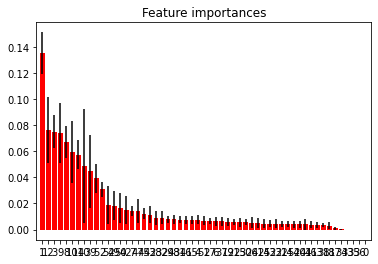

In [70]:
import numpy as np
importances = rf_results.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_results.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
for f in range(exog.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
import matplotlib.pyplot as plt

plt.figure()
plt.title("Feature importances")
plt.bar(range(exog.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(exog.shape[1]), indices)
plt.xlim([-1, exog.shape[1]])
plt.show()

In [ ]:
sm.add_constant(X_train)